In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## import

In [ ]:
!pip install ktrain

In [ ]:
import pandas as pd
import numpy as np
import ktrain
from ktrain import text
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### data

In [ ]:
data = pd.read_feather('/content/drive/MyDrive/CUAI_winter/clip.ftr')

In [ ]:
data.head()

,script,emotion
0,"야, 여기 있던 내 옷 못 봤어?",neutral
1,무슨 옷 말하는 건데?,fear
2,"그거, 내가 생일에 친구한테 선물받은 원피스!",angry
3,친구한테… 선물 받은 거?,fear
4,"그래, 그 남색에, 어깨 부분에 장식 달린 거 있잖아.",angry


In [ ]:
data.shape

(45447, 2)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45447 entries, 0 to 45446
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   script   45447 non-null  object
 1   emotion  45447 non-null  object
dtypes: object(2)
memory usage: 710.2+ KB


## 데이터 전처리

### 중립 감정 제거

In [ ]:
# 감정별 데이터 개수 확인
data['emotion'].value_counts()

neutral     19988
fear         6849
happy        4737
sad          4347
dislike      3932
surprise     3104
angry        1746
contempt      744
Name: emotion, dtype: int64

In [ ]:
# 중립 감정 제거
data = data[data['emotion'] != 'neutral']

In [ ]:
# 감정별 데이터 개수 확인
data['emotion'].value_counts()

fear        6849
happy       4737
sad         4347
dislike     3932
surprise    3104
angry       1746
contempt     744
Name: emotion, dtype: int64

### 감정 라벨 인코딩

In [ ]:
items = data['emotion']
encoder = LabelEncoder()
encoder.fit(items)
labels = encoder.transform(items)
data['emotion_ind'] = labels

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
data['emotion_ind'].value_counts()

3    6849
4    4737
5    4347
2    3932
6    3104
0    1746
1     744
Name: emotion_ind, dtype: int64

### train, test split

In [ ]:
# Train : test = 9 : 1
X_train, X_test, y_train, y_test = train_test_split(data.index.values,
                                                  data.emotion.values, 
                                                  test_size=0.1, 
                                                  random_state=42,
                                                  stratify= data.emotion.values)

In [ ]:
# data_type == train or test
data['data_type'] = ['not_set']*data.shape[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
data.head()

,script,emotion,emotion_ind,data_type
1,무슨 옷 말하는 건데?,fear,3,not_set
2,"그거, 내가 생일에 친구한테 선물받은 원피스!",angry,0,not_set
3,친구한테… 선물 받은 거?,fear,3,not_set
4,"그래, 그 남색에, 어깨 부분에 장식 달린 거 있잖아.",angry,0,not_set
5,아.. 그거… 그거 내가 저번에 한 번 입었어.,fear,3,not_set


In [ ]:
data.loc[X_train, 'data_type'] = 'train'
data.loc[X_test, 'data_type'] = 'test'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
# 감정 별 train, test 데이터 개수

data.groupby(['emotion', 'data_type']).count()

script  emotion_ind
emotion  data_type                     
angry    test          175          175
         train        1571         1571
contempt test           74           74
         train         670          670
dislike  test          393          393
         train        3539         3539
fear     test          685          685
         train        6164         6164
happy    test          474          474
         train        4263         4263
sad      test          435          435
         train        3912         3912
surprise test          310          310
         train        2794         2794

In [ ]:
# train, test split

df_train = data[data['data_type'] == 'train']
df_test = data[data['data_type'] == 'test']

In [ ]:
df_train.shape

(22913, 4)

In [ ]:
df_test.shape

(2546, 4)

In [ ]:
X_train = df_train['script'].tolist()
X_test = df_test['script'].tolist()
y_train = df_train['emotion_ind'].tolist()
y_test = df_test['emotion_ind'].tolist()

In [ ]:
# Checking size of our train and test datasets
print(len(X_train),len(X_test),len(y_train),len(y_test))

22913 2546 22913 2546


In [ ]:
factors = list(data.emotion.unique())
factors

['fear', 'angry', 'contempt', 'sad', 'surprise', 'dislike', 'happy']

## Building Model using Transformer

In [ ]:
model_arch = 'albert-large-v2'
# model_arch ='bert-base-uncased'
MAXLEN = 64
trans = text.Transformer(model_arch, maxlen = MAXLEN, class_names= factors)

In [ ]:
train_data = trans.preprocess_train(X_train, y_train)
test_data = trans.preprocess_test(X_test, y_test)

preprocessing train...
language: ko
train sequence lengths:
	mean : 8
	95percentile : 17
	99percentile : 25


Is Multi-Label? False
preprocessing test...
language: ko
test sequence lengths:
	mean : 8
	95percentile : 17
	99percentile : 25


In [ ]:
model = trans.get_classifier()

In [ ]:
learner = ktrain.get_learner(model, train_data=train_data, val_data=test_data, batch_size=64)

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
358/358 [==============================] - 516s 1s/step - loss: 1.8038 - accuracy: 0.2608
Epoch 2/5
358/358 [==============================] - 492s 1s/step - loss: 1.7123 - accuracy: 0.3068
Epoch 3/5
358/358 [==============================] - 492s 1s/step - loss: 1.9679 - accuracy: 0.2211
Epoch 4/5
358/358 [==============================] - 132s 367ms/step - loss: 9.1532 - accuracy: 0.1737


done.
Visually inspect loss plot and select learning rate associated with falling loss


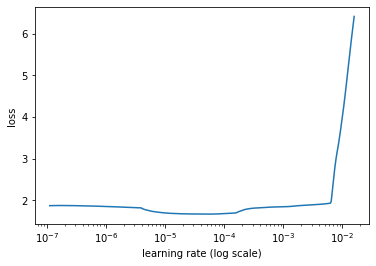

In [ ]:
learner.lr_find(show_plot=True, max_epochs=5)

In [ ]:
learner.fit_onecycle(lr = 2e-5, epochs = 2, checkpoint_folder='/content/drive/MyDrive/CUAI_winter/ktrain_learner/')



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/2
359/359 [==============================] - 564s 1s/step - loss: 1.6922 - accuracy: 0.3179 - val_loss: 1.6808 - val_accuracy: 0.3142
Epoch 2/2
359/359 [==============================] - 528s 1s/step - loss: 1.6308 - accuracy: 0.3464 - val_loss: 1.6221 - val_accuracy: 0.3606


In [ ]:
# # save model
learner.save_model('/content/drive/MyDrive/CUAI_winter/ktrain_model')

### Confusion matrix

In [ ]:
learner.validate(val_data=test_data, class_names=factors)

              precision    recall  f1-score   support

        fear       0.37      0.13      0.19       175
       angry       0.00      0.00      0.00        74
    contempt       0.31      0.03      0.05       393
         sad       0.42      0.56      0.48       685
    surprise       0.29      0.65      0.40       474
     dislike       0.37      0.29      0.32       435
       happy       0.58      0.23      0.33       310

    accuracy                           0.36      2546
   macro avg       0.33      0.27      0.25      2546
weighted avg       0.37      0.36      0.32      2546



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[ 22,   0,   4,  45,  81,  16,   7],
       [  5,   0,   3,  23,  37,   6,   0],
       [ 14,   0,  11, 101, 226,  35,   6],
       [  5,   0,   5, 382, 172,  86,  35],
       [  8,   0,  10,  95, 307,  51,   3],
       [  3,   0,   1, 121, 184, 125,   1],
       [  3,   0,   1, 152,  62,  21,  71]])

### loss top 10 data

In [ ]:
learner.view_top_losses(n=10, preproc=trans, val_data=test_data)

----------
id:1828 | loss:4.63 | true:angry | pred:dislike)

----------
id:913 | loss:4.63 | true:angry | pred:dislike)

----------
id:1786 | loss:4.39 | true:angry | pred:sad)

----------
id:2385 | loss:4.39 | true:angry | pred:sad)

----------
id:1790 | loss:4.15 | true:angry | pred:sad)

----------
id:2329 | loss:4.1 | true:angry | pred:dislike)

----------
id:2312 | loss:4.09 | true:angry | pred:dislike)

----------
id:1619 | loss:4.05 | true:angry | pred:dislike)

----------
id:1612 | loss:3.96 | true:angry | pred:sad)

----------
id:860 | loss:3.95 | true:angry | pred:sad)



In [ ]:
top_loss_10 = [1828, 913, 1786, 2385, 1790, 2329, 2312, 1619, 1612, 860]
for ind in top_loss_10:
   print(X_test[ind])

엄마가요.. 애들도 안 오는데, 뭐하러 돈 들여 파티를 하녜요..	 그냥 가족끼리 밥 먹쟤요..
나 오늘 학교에서 성훈이랑 엄청 싸웠는데… 성훈이를 엄청 팼거든..
안돼? 그럼 왜 아까는 된다고 그랬어?
뭐? 너 누나한테 누가 그렇게 대들어?
진짜라니까? 북어 완전, 성적 가지고 차별 엄청 한다니까?
미디어가 문제야 미디어가… 아휴옛날엔 너무 마르면 시집도 못 갔어
음… 아침에 10분 더 있으면 10분 더 잘 수 있잖아 그게 얼마나 달콤한데
...사람들이 나 보고 웃는 거 싫어요.
너... 엄마 서운하다?	 엄마는 엄마가 강원도까지 찾아와야 만나주고,	 여자친구랑은 부산까지 가고.
아니, 뭐 지 얼굴 보여주러 병문안 가나? 참… 경우 없는 사람이야.


### Predictor 저장

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=trans)

In [ ]:
predictor.save('/content/drive/MyDrive/CUAI_winter/ktrain_predictor/')